In [17]:
import torch
import torchaudio
from pathlib import Path
import numpy as np
import pandas as pd
from collections import defaultdict
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm



In [18]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROJECT_ROOT = Path.cwd().parents[1]
AUG_DIR = PROJECT_ROOT / "data/augmented_wavs"  # change if needed
DATA_DIR = PROJECT_ROOT / "data/wavs"

# Load pretrained ReDimNet (example config)
redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b2",      # or b3/b5/etc.
    train_type="ptn",     # or "ft_lm"/"ft_mix" depending what you want
    dataset="vox2",       # typical pretraining dataset
).to(DEVICE).eval()

# # # Save model layers to a text file
# model_str = repr(redim_model)
# with open("model_architecture.txt", "w") as f:
#     f.write(model_str)


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


In [19]:
def embed_with_redim(wav_path: str) -> np.ndarray:
    wav, sr = torchaudio.load(wav_path)   # [C, T]
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    if wav.shape[0] > 1:
        wav = wav[:1, :]                  # take first channel

    wav = wav.to(DEVICE)
    with torch.no_grad():
        emb = redim_model(wav)           # [1, 192]
    return emb.squeeze(0).cpu().numpy()       # [192]

In [20]:

wav_files = sorted(DATA_DIR.glob("*.wav"))

rows = []
for p in wav_files:
    stem = p.stem          # e.g. "idan_001"
    speaker = stem.split("_")[0]
    rows.append({"file": str(p), "speaker": speaker})

df = pd.DataFrame(rows)
print(df.head())
print("Total files:", len(df))
print("Speakers:", df["speaker"].unique())

                                               file speaker
0  /home/SpeakerRec/BioVoice/data/wavs/eden_001.wav    eden
1  /home/SpeakerRec/BioVoice/data/wavs/eden_002.wav    eden
2  /home/SpeakerRec/BioVoice/data/wavs/eden_003.wav    eden
3  /home/SpeakerRec/BioVoice/data/wavs/eden_004.wav    eden
4  /home/SpeakerRec/BioVoice/data/wavs/eden_005.wav    eden
Total files: 90
Speakers: ['eden' 'idan' 'yoav']


In [21]:

embs = []
for i, row in df.iterrows():
    vec = embed_with_redim(row["file"])
    embs.append(vec)

E = np.vstack(embs).astype("float32")  # [N, 192]
print("Embedding matrix shape:", E.shape)

# L2-normalize
E_norm = E / np.linalg.norm(E, axis=1, keepdims=True)


Embedding matrix shape: (90, 192)


In [22]:

GLOBAL_ENROLL_PER_SPK = 3 
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

groups = defaultdict(list)
for i, row in df.iterrows():
    groups[row["speaker"]].append(i)

enroll_idx = []
test_idx = []

for spk, idxs in groups.items():
    idxs = idxs.copy()
    random.shuffle(idxs)

    n_avail = len(idxs)
    if n_avail <= GLOBAL_ENROLL_PER_SPK:
        n_enroll = max(1, n_avail - 1)  # keep at least 1 test if we can
    else:
        n_enroll = GLOBAL_ENROLL_PER_SPK

    enroll_for_spk = idxs[:n_enroll]
    test_for_spk = idxs[n_enroll:]

    enroll_idx.extend(enroll_for_spk)
    test_idx.extend(test_for_spk)

enroll_idx = np.array(sorted(enroll_idx))
test_idx = np.array(sorted(test_idx))

print("Enrollment per speaker:", GLOBAL_ENROLL_PER_SPK)
print("Total enrollment files:", len(enroll_idx))
print("Total test files:", len(test_idx))


Enrollment per speaker: 3
Total enrollment files: 9
Total test files: 81


In [23]:

enroll_emb = E_norm[enroll_idx]
test_emb   = E_norm[test_idx]

enroll_labels = df.iloc[enroll_idx]["speaker"].to_numpy()
test_labels   = df.iloc[test_idx]["speaker"].to_numpy()

pred_labels = []

for e in test_emb:
    sims = cosine_similarity(e.reshape(1, -1), enroll_emb)[0]  # [N_enroll]
    best = np.argmax(sims)
    pred_labels.append(enroll_labels[best])

pred_labels = np.array(pred_labels)

accuracy = (pred_labels == test_labels).mean()
print(f"\nOverall accuracy: {accuracy:.4f}")



Overall accuracy: 1.0000


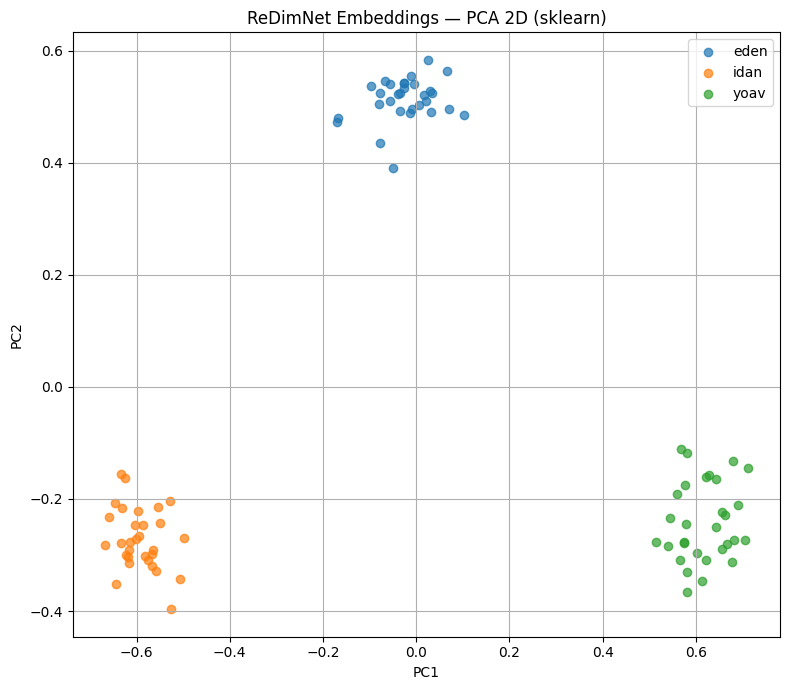

In [24]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Fit PCA on all embeddings
pca = PCA(n_components=3, random_state=0)
X_pca = pca.fit_transform(E_norm)   # shape [N, 3]

pca2d = X_pca[:, :2]   # first 2 PCs
pca3d = X_pca          # 3 PCs

speakers = df["speaker"].unique()

plt.figure(figsize=(8, 7))

for spk in speakers:
    idx = (df["speaker"] == spk)
    plt.scatter(pca2d[idx, 0], pca2d[idx, 1], alpha=0.7, label=spk)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet Embeddings — PCA 2D (sklearn)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



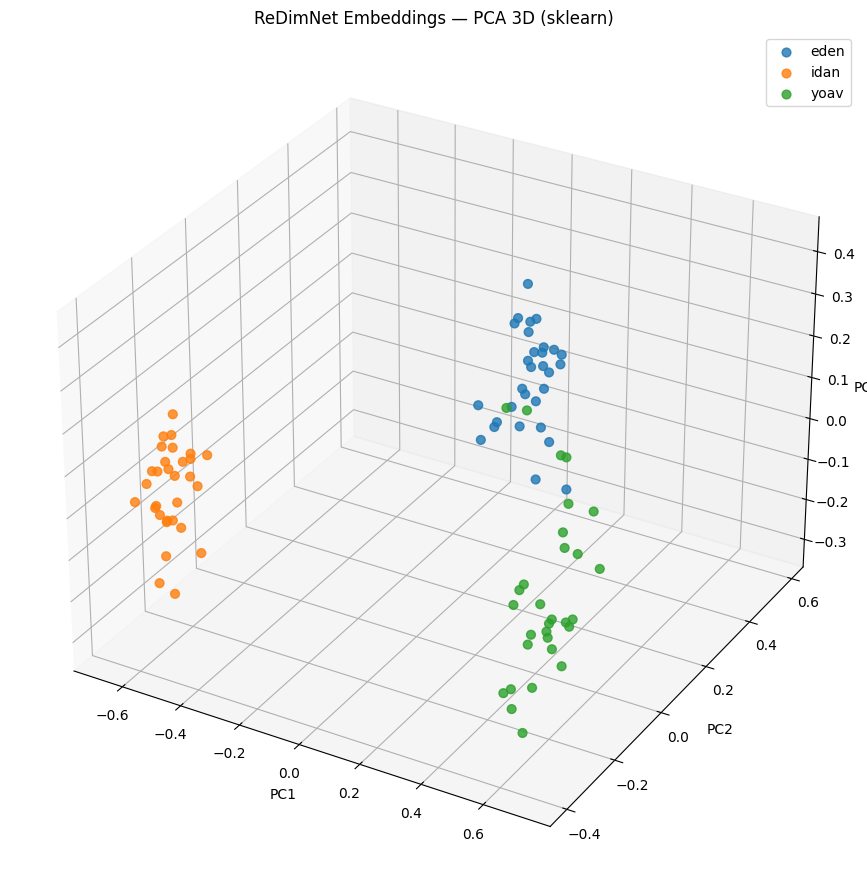

In [25]:
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection="3d")

for spk in speakers:
    idx = (df["speaker"] == spk)
    ax.scatter(
        pca3d[idx, 0],
        pca3d[idx, 1],
        pca3d[idx, 2],
        s=40,
        alpha=0.8,
        label=spk,
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("ReDimNet Embeddings — PCA 3D (sklearn)")
ax.legend()
plt.tight_layout()
plt.show()


In [26]:
# %%
# Robustness eval: load augmented dataset


aug_wav_files = sorted(AUG_DIR.rglob("*.wav"))
print("AUG_DIR:", AUG_DIR)
print("Aug wav count:", len(aug_wav_files))

aug_rows = []
for p in aug_wav_files:
    stem = p.stem  # e.g. "idan_001_aug-SNR"
    if "_aug-" not in stem:
        continue

    base_stem, aug_tag = stem.split("_aug-", 1)  # base_stem="idan_001", aug_tag="SNR"
    speaker = base_stem.split("_")[0]

    aug_rows.append(
        {
            "file": str(p),
            "speaker": speaker,
            "base_stem": base_stem,
            "aug_tag": aug_tag,  # "SNR" / "pitch" / "SNR-pitch"
        }
    )

df_aug = pd.DataFrame(aug_rows)
print(df_aug.head())
print("Aug tags:", sorted(df_aug["aug_tag"].unique()))
print("Speakers:", sorted(df_aug["speaker"].unique()))


AUG_DIR: /home/SpeakerRec/BioVoice/data/augmented_wavs
Aug wav count: 270
                                                file speaker base_stem  \
0  /home/SpeakerRec/BioVoice/data/augmented_wavs/...    eden  eden_001   
1  /home/SpeakerRec/BioVoice/data/augmented_wavs/...    eden  eden_001   
2  /home/SpeakerRec/BioVoice/data/augmented_wavs/...    eden  eden_001   
3  /home/SpeakerRec/BioVoice/data/augmented_wavs/...    eden  eden_002   
4  /home/SpeakerRec/BioVoice/data/augmented_wavs/...    eden  eden_002   

     aug_tag  
0  SNR-pitch  
1        SNR  
2      pitch  
3  SNR-pitch  
4        SNR  
Aug tags: ['SNR', 'SNR-pitch', 'pitch']
Speakers: ['eden', 'idan', 'yoav']


In [27]:
# %%
# Build a set of enrollment base_stems (to prevent leakage: don't test augmented versions of enrollment utterances)

enroll_files = df.iloc[enroll_idx]["file"].tolist()
enroll_base_stems = set(Path(f).stem for f in enroll_files)  # clean stems like "idan_001"

before = len(df_aug)
df_aug = df_aug[~df_aug["base_stem"].isin(enroll_base_stems)].reset_index(drop=True)
after = len(df_aug)

print(f"Filtered augmented files that correspond to enrollment utterances: {before} -> {after}")


Filtered augmented files that correspond to enrollment utterances: 270 -> 243


In [28]:
# %%
# Embed augmented files (optional cache to avoid recomputing)

CACHE_DIR = PROJECT_ROOT / "output"
CACHE_DIR.mkdir(parents=True, exist_ok=True)
cache_path = CACHE_DIR / "redim_aug_embeddings_b2_vox2.npz"

def compute_embeddings_with_cache(df_in: pd.DataFrame, cache_file: Path) -> np.ndarray:
    files = df_in["file"].tolist()

    if cache_file.exists():
        pack = np.load(cache_file, allow_pickle=True)
        cached_files = pack["files"].tolist()
        if cached_files == files:
            print("Loaded embeddings from cache:", cache_file)
            return pack["E"].astype("float32")

    embs = []
    for f in tqdm(files, desc="Embedding augmented"):
        embs.append(embed_with_redim(f))
    E_out = np.vstack(embs).astype("float32")

    np.savez_compressed(cache_file, files=np.array(files, dtype=object), E=E_out)
    print("Saved embeddings cache to:", cache_file)
    return E_out

E_aug = compute_embeddings_with_cache(df_aug, cache_path)

# L2-normalize
E_aug_norm = E_aug / np.linalg.norm(E_aug, axis=1, keepdims=True)
print("E_aug_norm shape:", E_aug_norm.shape)


Embedding augmented:   0%|          | 0/243 [00:00<?, ?it/s]

Embedding augmented: 100%|██████████| 243/243 [00:08<00:00, 30.30it/s]

Saved embeddings cache to: /home/SpeakerRec/BioVoice/output/redim_aug_embeddings_b2_vox2.npz
E_aug_norm shape: (243, 192)


In [29]:
# %%
# Evaluate: predict speakers for augmented files using clean enrollment

from sklearn.metrics import confusion_matrix, classification_report

def predict_labels(test_emb: np.ndarray, enroll_emb: np.ndarray, enroll_labels: np.ndarray) -> np.ndarray:
    preds = []
    for e in tqdm(test_emb, desc="Predicting"):
        sims = cosine_similarity(e.reshape(1, -1), enroll_emb)[0]
        best = int(np.argmax(sims))
        preds.append(enroll_labels[best])
    return np.array(preds)

aug_true = df_aug["speaker"].to_numpy()
aug_pred = predict_labels(E_aug_norm, enroll_emb, enroll_labels)

df_aug["pred"] = aug_pred
df_aug["correct"] = (df_aug["pred"] == df_aug["speaker"])

overall_acc = df_aug["correct"].mean() if len(df_aug) else float("nan")
print(f"Augmented overall accuracy (vs clean enrollment): {overall_acc:.4f}")

# Accuracy by augmentation type
acc_by_tag = df_aug.groupby("aug_tag")["correct"].mean().sort_index()
print("\nAccuracy by aug_tag:")
print(acc_by_tag)

# Accuracy by speaker (overall)
acc_by_spk = df_aug.groupby("speaker")["correct"].mean().sort_index()
print("\nAccuracy by speaker:")
print(acc_by_spk)


Predicting: 100%|██████████| 243/243 [00:00<00:00, 2113.73it/s]

Augmented overall accuracy (vs clean enrollment): 1.0000

Accuracy by aug_tag:
aug_tag
SNR          1.0
SNR-pitch    1.0
pitch        1.0
Name: correct, dtype: float64

Accuracy by speaker:
speaker
eden    1.0
idan    1.0
yoav    1.0
Name: correct, dtype: float64



--- Confusion matrix: SNR ---
[[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]
              precision    recall  f1-score   support

        eden       1.00      1.00      1.00        27
        idan       1.00      1.00      1.00        27
        yoav       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



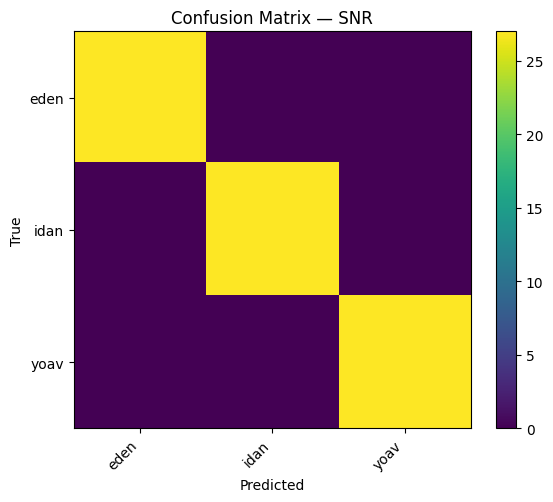


--- Confusion matrix: SNR-pitch ---
[[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]
              precision    recall  f1-score   support

        eden       1.00      1.00      1.00        27
        idan       1.00      1.00      1.00        27
        yoav       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



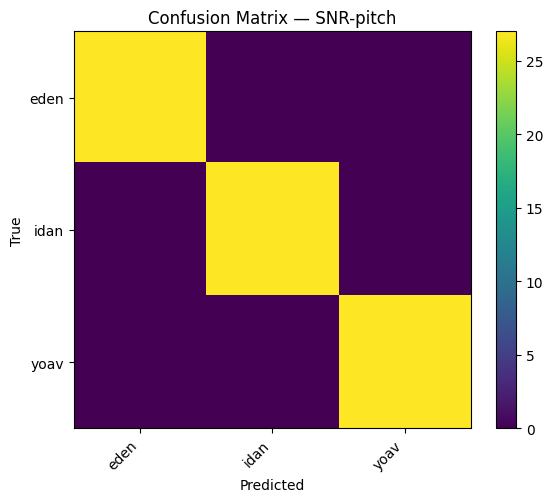


--- Confusion matrix: pitch ---
[[27  0  0]
 [ 0 27  0]
 [ 0  0 27]]
              precision    recall  f1-score   support

        eden       1.00      1.00      1.00        27
        idan       1.00      1.00      1.00        27
        yoav       1.00      1.00      1.00        27

    accuracy                           1.00        81
   macro avg       1.00      1.00      1.00        81
weighted avg       1.00      1.00      1.00        81



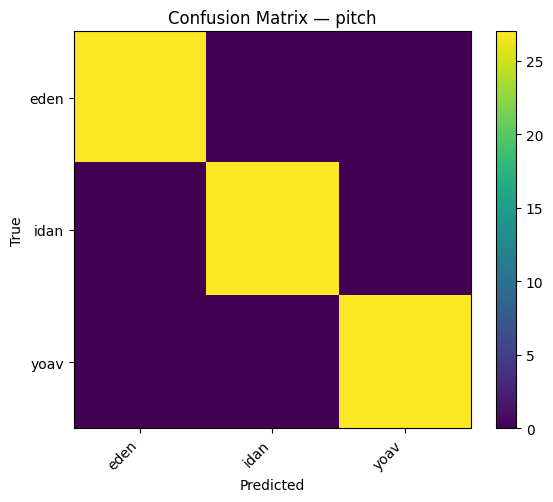

In [30]:
# %%
# Confusion matrix per augmentation type (prints + plots)

import matplotlib.pyplot as plt

labels = sorted(df["speaker"].unique())  # your clean speakers list (idan/eden/yoav)
label_to_idx = {l: i for i, l in enumerate(labels)}

def plot_confusion(cm: np.ndarray, labels: list[str], title: str):
    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for tag in sorted(df_aug["aug_tag"].unique()):
    sub = df_aug[df_aug["aug_tag"] == tag]
    y_true = sub["speaker"].to_numpy()
    y_pred = sub["pred"].to_numpy()

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    print(f"\n--- Confusion matrix: {tag} ---")
    print(cm)
    print(classification_report(y_true, y_pred, labels=labels, zero_division=0))

    plot_confusion(cm, labels, title=f"Confusion Matrix — {tag}")


In [31]:
# %%
# Optional robustness metric: similarity of augmented embedding to its clean original (same utterance)

# Build mapping clean_stem -> clean embedding (you already have E_norm for df)
clean_stems = [Path(p).stem for p in df["file"].tolist()]
stem_to_clean_emb = {s: E_norm[i] for i, s in enumerate(clean_stems)}

sims = []
missing = 0
for i, row in df_aug.iterrows():
    base = row["base_stem"]
    if base not in stem_to_clean_emb:
        missing += 1
        sims.append(np.nan)
        continue
    # both are normalized => cosine = dot
    sims.append(float(np.dot(E_aug_norm[i], stem_to_clean_emb[base])))

df_aug["sim_to_clean"] = sims
print("Missing base stems (no matching clean file):", missing)

print("\nMean sim_to_clean by aug_tag:")
print(df_aug.groupby("aug_tag")["sim_to_clean"].agg(["mean", "std", "count"]).sort_index())


Missing base stems (no matching clean file): 0

Mean sim_to_clean by aug_tag:
               mean       std  count
aug_tag                             
SNR        0.702240  0.142975     81
SNR-pitch  0.572836  0.160113     81
pitch      0.784335  0.156811     81


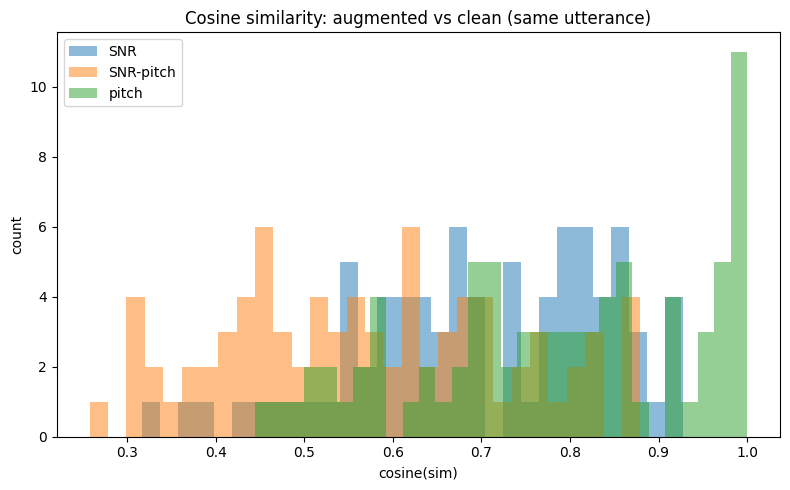

In [32]:
# %%
# Plot similarity distributions per augmentation type

plt.figure(figsize=(8, 5))
for tag in sorted(df_aug["aug_tag"].unique()):
    x = df_aug.loc[df_aug["aug_tag"] == tag, "sim_to_clean"].dropna().to_numpy()
    if len(x) == 0:
        continue
    plt.hist(x, bins=30, alpha=0.5, label=tag)

plt.title("Cosine similarity: augmented vs clean (same utterance)")
plt.xlabel("cosine(sim)")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


In [37]:
# %%
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA on CLEAN embeddings only, then project AUG into the same space
pca = PCA(n_components=2, random_state=0)
pca.fit(E_norm)

clean_2d = pca.transform(E_norm)         # shape [N_clean, 2]
aug_2d   = pca.transform(E_aug_norm)     # shape [N_aug, 2]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (2D):", pca.explained_variance_ratio_.sum())


PCA explained variance ratio: [0.3638785  0.19862269]
Total explained variance (2D): 0.5625012


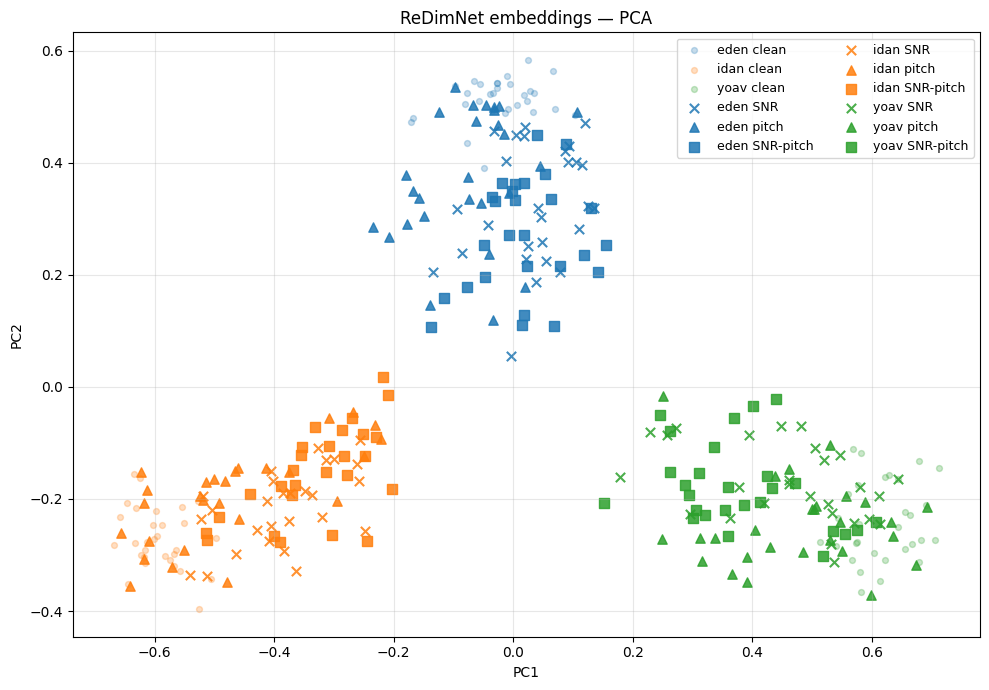

In [39]:
# %%
import numpy as np

speakers = sorted(df["speaker"].unique())

# Use matplotlib's default color cycle so each speaker is consistent
default_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
color_map = {
    spk: default_colors[i % len(default_colors)] if default_colors else None
    for i, spk in enumerate(speakers)
}

marker_by_tag = {
    "SNR": "x",
    "pitch": "^",
    "SNR-pitch": "s",
}

plt.figure(figsize=(10, 7))

# Plot CLEAN
for spk in speakers:
    idx = (df["speaker"].to_numpy() == spk)
    plt.scatter(
        clean_2d[idx, 0],
        clean_2d[idx, 1],
        s=18,
        alpha=0.25,
        c=color_map[spk],
        label=f"{spk} clean",
    )

# Plot AUGMENTED (same speaker color, different marker per aug_tag)
for spk in speakers:
    for tag, marker in marker_by_tag.items():
        sub = df_aug[(df_aug["speaker"] == spk) & (df_aug["aug_tag"] == tag)]
        if len(sub) == 0:
            continue

        idx = sub.index.to_numpy()
        plt.scatter(
            aug_2d[idx, 0],
            aug_2d[idx, 1],
            s=45,
            alpha=0.85,
            c=color_map[spk],
            marker=marker,
            label=f"{spk} {tag}",
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet embeddings — PCA")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()
